In [1]:
#import numpy as cp
import cupy as cp

import matplotlib.pyplot as plt
from PIL import Image

from load_dataset import load_dataset

In [2]:
# set path vars

#dataset_path = "C:\\Users\\user\\PycharmProjects\\my_cnn\\mnist_png"
dataset_path = 'mnist_png'

In [3]:
# activation functions and their derivatives

# sigmoid
def sigmoid(x):
    return 1/(1+cp.exp(-x))

#sigmoid derivative
def sigmoid_d(x):
    return cp.exp(-x) / cp.power(1 + cp.exp(-x), 2.)

In [4]:
# load the MNIST dataset

dataset = load_dataset(dataset_path)
X = dataset['train']['X']
Y = dataset['train']['Y']

In [5]:
# convert X, Y to CuPy arrays

X = cp.array(X)
Y = cp.array(Y)

In [6]:
# set the layer sizes

layer_sizes = [
    X.shape[0],
    500,
    100,
    10
]

In [7]:
# initialize parameters

W1 = cp.random.randn(layer_sizes[1], layer_sizes[0])
b1 = cp.zeros((layer_sizes[1], 1))

W2 = cp.random.randn(layer_sizes[2], layer_sizes[1])
b2 = cp.zeros((layer_sizes[2], 1))

W3 = cp.random.randn(layer_sizes[3], layer_sizes[2])
b3 = cp.zeros((layer_sizes[3], 1))

In [ ]:
# train the model

iterations = 2500
print_cost = True

samples = X.shape[1] # number of training samples (60000 here)

learning_rate = 0.00001

cost = .0

for i in range(iterations):

    # forward propagation
    #   push icput data through the network
    Z1 = cp.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    Z2 = cp.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = cp.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # MSE
    #   cost function, to compute the error
    cost = cp.sum(cp.power(Y - A3, 2.)) / samples
    # cost = -1 / samples * sum([Y[0][i] * cp.log(A3[0][i]) + (1 - Y[0][i]) * cp.log(1 - AL[0][i]) for i in range(AL.shape[1])])

    if print_cost and i % 5 == 0:
        print('Cost: {} @ i = {}'.format(cost, i))


    # backward propagation
    #   adjust the weights and biases to fit the data

    # compute the derivatives of the weights and biases
    # dW3
    dA3 = 2 * (Y - A3)
    dZ3 = sigmoid_d(A3)
    dW3 = cp.dot(dA3 * dZ3, A2.T)
    db3 = cp.sum(dZ3, axis=1, keepdims=True)

    # dW2
    dA2 = cp.dot(W3.T, dA3 * dZ3)
    dZ2 = sigmoid_d(A2)
    dW2 = cp.dot(dA2 * dZ2, A1.T)
    db2 = cp.sum(dZ2, axis=1, keepdims=True)

    # dW1
    dA1 = cp.dot(W2.T, dA2 * dZ2)
    dZ1 = sigmoid_d(A1)
    dW1 = cp.dot(dA1 * dZ1, X.T)
    db1 = cp.sum(dZ1, axis=1, keepdims=True)


    # update parameters
    W1 += learning_rate * dW1
    W2 += learning_rate * dW2
    W3 += learning_rate * dW3

    b1 += learning_rate * db1
    b2 += learning_rate * db2
    b3 += learning_rate * db3

Cost: 3.0085962100378394 @ i = 0
Cost: 0.9846798771782652 @ i = 5
Cost: 0.7070645663134347 @ i = 10
Cost: 0.7782126379605219 @ i = 15
Cost: 0.6734366079910048 @ i = 20
Cost: 0.6015945700643497 @ i = 25
Cost: 0.5755249171845113 @ i = 30
Cost: 0.511271657729383 @ i = 35
Cost: 0.5373388850820119 @ i = 40
Cost: 0.5281516456534002 @ i = 45
Cost: 0.5014549016886937 @ i = 50
Cost: 0.48873394724529656 @ i = 55
Cost: 0.6189361264370218 @ i = 60
Cost: 0.5821247635171843 @ i = 65
Cost: 0.5180312984468418 @ i = 70
Cost: 0.5414694576566111 @ i = 75
Cost: 0.5314608861608197 @ i = 80
Cost: 0.5200276934406652 @ i = 85
Cost: 0.6202068967779102 @ i = 90
Cost: 0.5902549914670238 @ i = 95
Cost: 0.5181080825999074 @ i = 100
Cost: 0.5011296699554622 @ i = 105
Cost: 0.46904707205202273 @ i = 110
Cost: 0.4810016372588687 @ i = 115
Cost: 0.6515923408917151 @ i = 120
Cost: 0.5367569479533297 @ i = 125
Cost: 0.5948223012101308 @ i = 130
Cost: 0.5786514801535327 @ i = 135
Cost: 0.5400671800563374 @ i = 140
Cost: 

[[4.63899183e-02]
 [1.19171803e-01]
 [8.31428322e-07]
 [1.83904681e-03]
 [1.18658392e-04]
 [1.84098189e-04]
 [2.49944049e-05]
 [7.10426175e-06]
 [1.58282508e-04]
 [1.61501315e-05]]


<ipython-input-10-b470dc76b000>:4: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


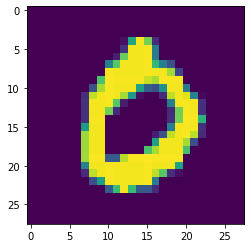

In [33]:
# load a sample image from the test dataset
# to evaluate the model

img = cp.asarray(
        Image.open(
            dataset_path + "\\testing\\0\\3.png"
        )
    )
plt.imshow(img)
img = img.reshape((img.shape[0] * img.shape[1]))[:, cp.newaxis]

X_n = img

# predict
Z1 = cp.dot(W1, X_n) + b1
A1 = sigmoid(Z1)

Z2 = cp.dot(W2, A1) + b2
A2 = sigmoid(Z2)

Z3 = cp.dot(W3, A2) + b3
A3 = sigmoid(Z3)

print(A3)
